Exploratory Data Analysis

In [10]:
import os
import wfdb
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

In [11]:
# Configuration
PATH = "D:/skripsi_teknis/dataset/mitbih-afdb"

Data Discovery and Loading

In [12]:
# Discover records
records = [f.replace(".hea", "") for f in os.listdir(PATH) if f.endswith(".hea")]
print(f"Found {len(records)} records in dataset")
print(f"Records: {', '.join(sorted(records))}")

# %%
# Extract comprehensive metadata
print("Extracting comprehensive metadata...")

metadata_rows = []
detailed_rows = []
signal_stats = {}

for rec in tqdm(records, desc="Processing records"):
    try:
        # Load record and annotations
        record = wfdb.rdrecord(os.path.join(PATH, rec))
        ann = wfdb.rdann(os.path.join(PATH, rec), "atr")
        
        # Basic metadata
        fs = record.fs
        sig_len = record.sig_len
        duration_sec = sig_len / fs
        channels = record.sig_name
        
        # Signal statistics
        signal_data = record.p_signal[:, 0]  # First channel
        signal_mean = np.mean(signal_data)
        signal_std = np.std(signal_data)
        signal_range = np.max(signal_data) - np.min(signal_data)
        
        # Simple signal quality score (SNR-based)
        noise_estimate = np.std(np.diff(signal_data))
        snr = signal_std / noise_estimate if noise_estimate > 0 else 10
        quality_score = min(10, max(1, snr / 10))
        
        # Annotation analysis
        labels = [label.strip() if label else 'Unknown' for label in ann.aux_note]
        times = ann.sample / fs
        
        # Calculate segment durations
        seg_durations = Counter()
        seg_counts = Counter()
        
        for i in range(len(labels) - 1):
            label = labels[i]
            duration = times[i+1] - times[i]
            seg_durations[label] += duration
            seg_counts[label] += 1
        
        # Add final segment
        if len(labels) > 0:
            final_duration = duration_sec - times[-1] if len(times) > 0 else duration_sec
            if final_duration > 0:
                final_label = labels[-1] if labels else 'Unknown'
                seg_durations[final_label] += final_duration
                seg_counts[final_label] += 1
        
        # Calculate rhythm percentages
        total_duration = sum(seg_durations.values())
        rhythm_percentages = {label: (dur/total_duration)*100 for label, dur in seg_durations.items()}
        
        # Primary and secondary rhythms
        sorted_rhythms = sorted(rhythm_percentages.items(), key=lambda x: x[1], reverse=True)
        primary_rhythm = sorted_rhythms[0][0] if sorted_rhythms else 'Unknown'
        primary_pct = sorted_rhythms[0][1] if sorted_rhythms else 0
        
        # Record-level metadata
        metadata_rows.append({
            'record': rec,
            'sampling_freq': fs,
            'duration_sec': duration_sec,
            'duration_min': duration_sec / 60,
            'duration_hours': duration_sec / 3600,
            'num_channels': len(channels),
            'total_annotations': len(labels),
            'unique_rhythms': len(set(labels)),
            'primary_rhythm': primary_rhythm,
            'primary_rhythm_pct': primary_pct,
            'signal_mean': signal_mean,
            'signal_std': signal_std,
            'signal_range': signal_range,
            'signal_quality_score': round(quality_score, 2)
        })
        
        # Detailed annotation data
        for label, duration in seg_durations.items():
            detailed_rows.append({
                'record': rec,
                'rhythm_label': label,
                'total_duration_sec': duration,
                'total_duration_min': duration / 60,
                'percentage_of_record': (duration / total_duration) * 100,
                'segment_count': seg_counts[label],
                'avg_segment_duration': duration / seg_counts[label] if seg_counts[label] > 0 else 0
            })
        
    except Exception as e:
        print(f"Error processing {rec}: {e}")

# Create DataFrames
metadata_df = pd.DataFrame(metadata_rows)
detailed_df = pd.DataFrame(detailed_rows)

print(f"Processed {len(metadata_rows)} records successfully")

Found 23 records in dataset
Records: 04015, 04043, 04048, 04126, 04746, 04908, 04936, 05091, 05121, 05261, 06426, 06453, 06995, 07162, 07859, 07879, 07910, 08215, 08219, 08378, 08405, 08434, 08455
Extracting comprehensive metadata...


Processing records: 100%|██████████| 23/23 [00:58<00:00,  2.54s/it]

Processed 23 records successfully


Dataset Overview

In [13]:
# Dataset summary statistics
total_duration_hours = metadata_df['duration_hours'].sum()
avg_duration_minutes = metadata_df['duration_min'].mean()

print("=== DATASET OVERVIEW ===")
print(f"Total records: {len(metadata_df)}")
print(f"Total duration: {total_duration_hours:.2f} hours ({total_duration_hours*60:.1f} minutes)")
print(f"Average record duration: {avg_duration_minutes:.2f} minutes")
print(f"Sampling frequencies: {sorted(metadata_df['sampling_freq'].unique())} Hz")
print(f"Number of channels per record: {sorted(metadata_df['num_channels'].unique())}")

# %%
# Rhythm distribution summary
rhythm_summary = detailed_df.groupby('rhythm_label').agg({
    'total_duration_sec': 'sum',
    'segment_count': 'sum',
    'record': 'nunique'
}).round(2)

rhythm_summary['total_duration_hours'] = rhythm_summary['total_duration_sec'] / 3600
rhythm_summary['percentage_of_dataset'] = (rhythm_summary['total_duration_sec'] / rhythm_summary['total_duration_sec'].sum()) * 100
rhythm_summary['avg_segment_duration_sec'] = rhythm_summary['total_duration_sec'] / rhythm_summary['segment_count']

rhythm_summary = rhythm_summary.sort_values('total_duration_hours', ascending=False)

print("\n=== RHYTHM DISTRIBUTION ===")
display(rhythm_summary[['total_duration_hours', 'percentage_of_dataset', 'segment_count', 'record']].round(2))

=== DATASET OVERVIEW ===
Total records: 23
Total duration: 234.28 hours (14056.8 minutes)
Average record duration: 611.16 minutes
Sampling frequencies: [np.int64(250)] Hz
Number of channels per record: [np.int64(2)]

=== RHYTHM DISTRIBUTION ===


,total_duration_hours,percentage_of_dataset,segment_count,record
rhythm_label,,,,
(N,139.16,59.40,288,21
(AFIB,93.40,39.87,291,23
(AFL,1.63,0.70,14,8
(J,0.09,0.04,12,3


Detailed Per-Record Analysis

In [14]:
# Enhanced per-record analysis with proper Normal rhythm identification
# Define rhythm categories properly
af_labels = ['(AFIB', 'AFIB']
normal_labels = ['(N', 'N', 'NSR']

# Get AF data
af_data = detailed_df[detailed_df['rhythm_label'].isin(af_labels)]
af_summary = af_data.groupby('record').agg({
    'total_duration_min': 'sum',
    'percentage_of_record': 'sum',
    'segment_count': 'sum'
}).round(2)
af_summary.columns = ['af_duration_min', 'af_percentage', 'af_segments']
af_summary = af_summary.fillna(0)

# Get Normal data
normal_data = detailed_df[detailed_df['rhythm_label'].isin(normal_labels)]
normal_summary = normal_data.groupby('record').agg({
    'total_duration_min': 'sum',
    'percentage_of_record': 'sum',
    'segment_count': 'sum'
}).round(2)
normal_summary.columns = ['normal_duration_min', 'normal_percentage', 'normal_segments']
normal_summary = normal_summary.fillna(0)

# Merge with metadata
enhanced_metadata = metadata_df.merge(af_summary, left_on='record', right_index=True, how='left')
enhanced_metadata = enhanced_metadata.merge(normal_summary, left_on='record', right_index=True, how='left')

# Fill NaN values
for col in ['af_duration_min', 'af_percentage', 'af_segments', 'normal_duration_min', 'normal_percentage', 'normal_segments']:
    enhanced_metadata[col] = enhanced_metadata[col].fillna(0)

# Categorize records based on both AF and Normal content
def categorize_record(row):
    af_pct = row['af_percentage']
    normal_pct = row['normal_percentage']
    
    if af_pct > 50:
        return 'AF-Dominant'
    elif normal_pct > 50:
        return 'Normal-Dominant'
    elif af_pct > 10 and normal_pct > 10:
        return 'Mixed AF-Normal'
    elif af_pct > 0 and normal_pct > 0:
        return 'Both Present'
    elif af_pct > 0:
        return 'AF-Only'
    elif normal_pct > 0:
        return 'Normal-Only'
    else:
        return 'Other Rhythms'

enhanced_metadata['record_category'] = enhanced_metadata.apply(categorize_record, axis=1)

# Display detailed analysis with Normal rhythm info
display_cols = [
    'record', 'duration_min', 'primary_rhythm', 'primary_rhythm_pct',
    'normal_percentage', 'af_percentage', 'unique_rhythms', 'total_annotations', 'record_category'
]

detailed_analysis = enhanced_metadata[display_cols].round(2)
print("=== DETAILED RECORD ANALYSIS (with Normal & AF) ===")
display(detailed_analysis)

# %%
# Category summary
category_summary = enhanced_metadata.groupby('record_category').agg({
    'record': 'count',
    'duration_min': ['mean', 'sum'],
    'af_percentage': 'mean',
    'signal_quality_score': 'mean'
}).round(2)

print("\n=== RECORD CATEGORY SUMMARY ===")
display(category_summary)

=== DETAILED RECORD ANALYSIS (with Normal & AF) ===


,record,duration_min,primary_rhythm,primary_rhythm_pct,normal_percentage,af_percentage,unique_rhythms,total_annotations,record_category
0,04015,613.72,(N,99.36,99.36,0.64,2,15,Normal-Dominant
1,04043,613.72,(N,78.46,78.46,21.51,3,166,Normal-Dominant
2,04048,613.72,(N,99.02,99.02,0.98,2,15,Normal-Dominant
3,04126,613.72,(N,96.26,96.26,3.74,2,15,Normal-Dominant
4,04746,613.72,(AFIB,53.10,46.90,53.10,2,11,AF-Dominant
5,04908,613.72,(N,90.94,90.94,8.37,3,17,Normal-Dominant
6,04936,613.72,(AFIB,72.13,18.66,72.13,3,73,AF-Dominant
7,05091,613.72,(N,99.76,99.76,0.24,2,17,Normal-Dominant
8,05121,613.72,(AFIB,63.03,36.35,63.03,3,42,AF-Dominant
9,05261,613.72,(N,98.70,98.70,1.30,2,23,Normal-Dominant



=== RECORD CATEGORY SUMMARY ===


record duration_min          af_percentage  \
                 count         mean      sum          mean   
record_category                                              
AF-Dominant         10       613.72  6137.17         76.59   
Normal-Dominant     13       609.20  7919.61         11.33   

                signal_quality_score  
                                mean  
record_category                       
AF-Dominant                      1.0  
Normal-Dominant                  1.0

Comprehensive Visualizations

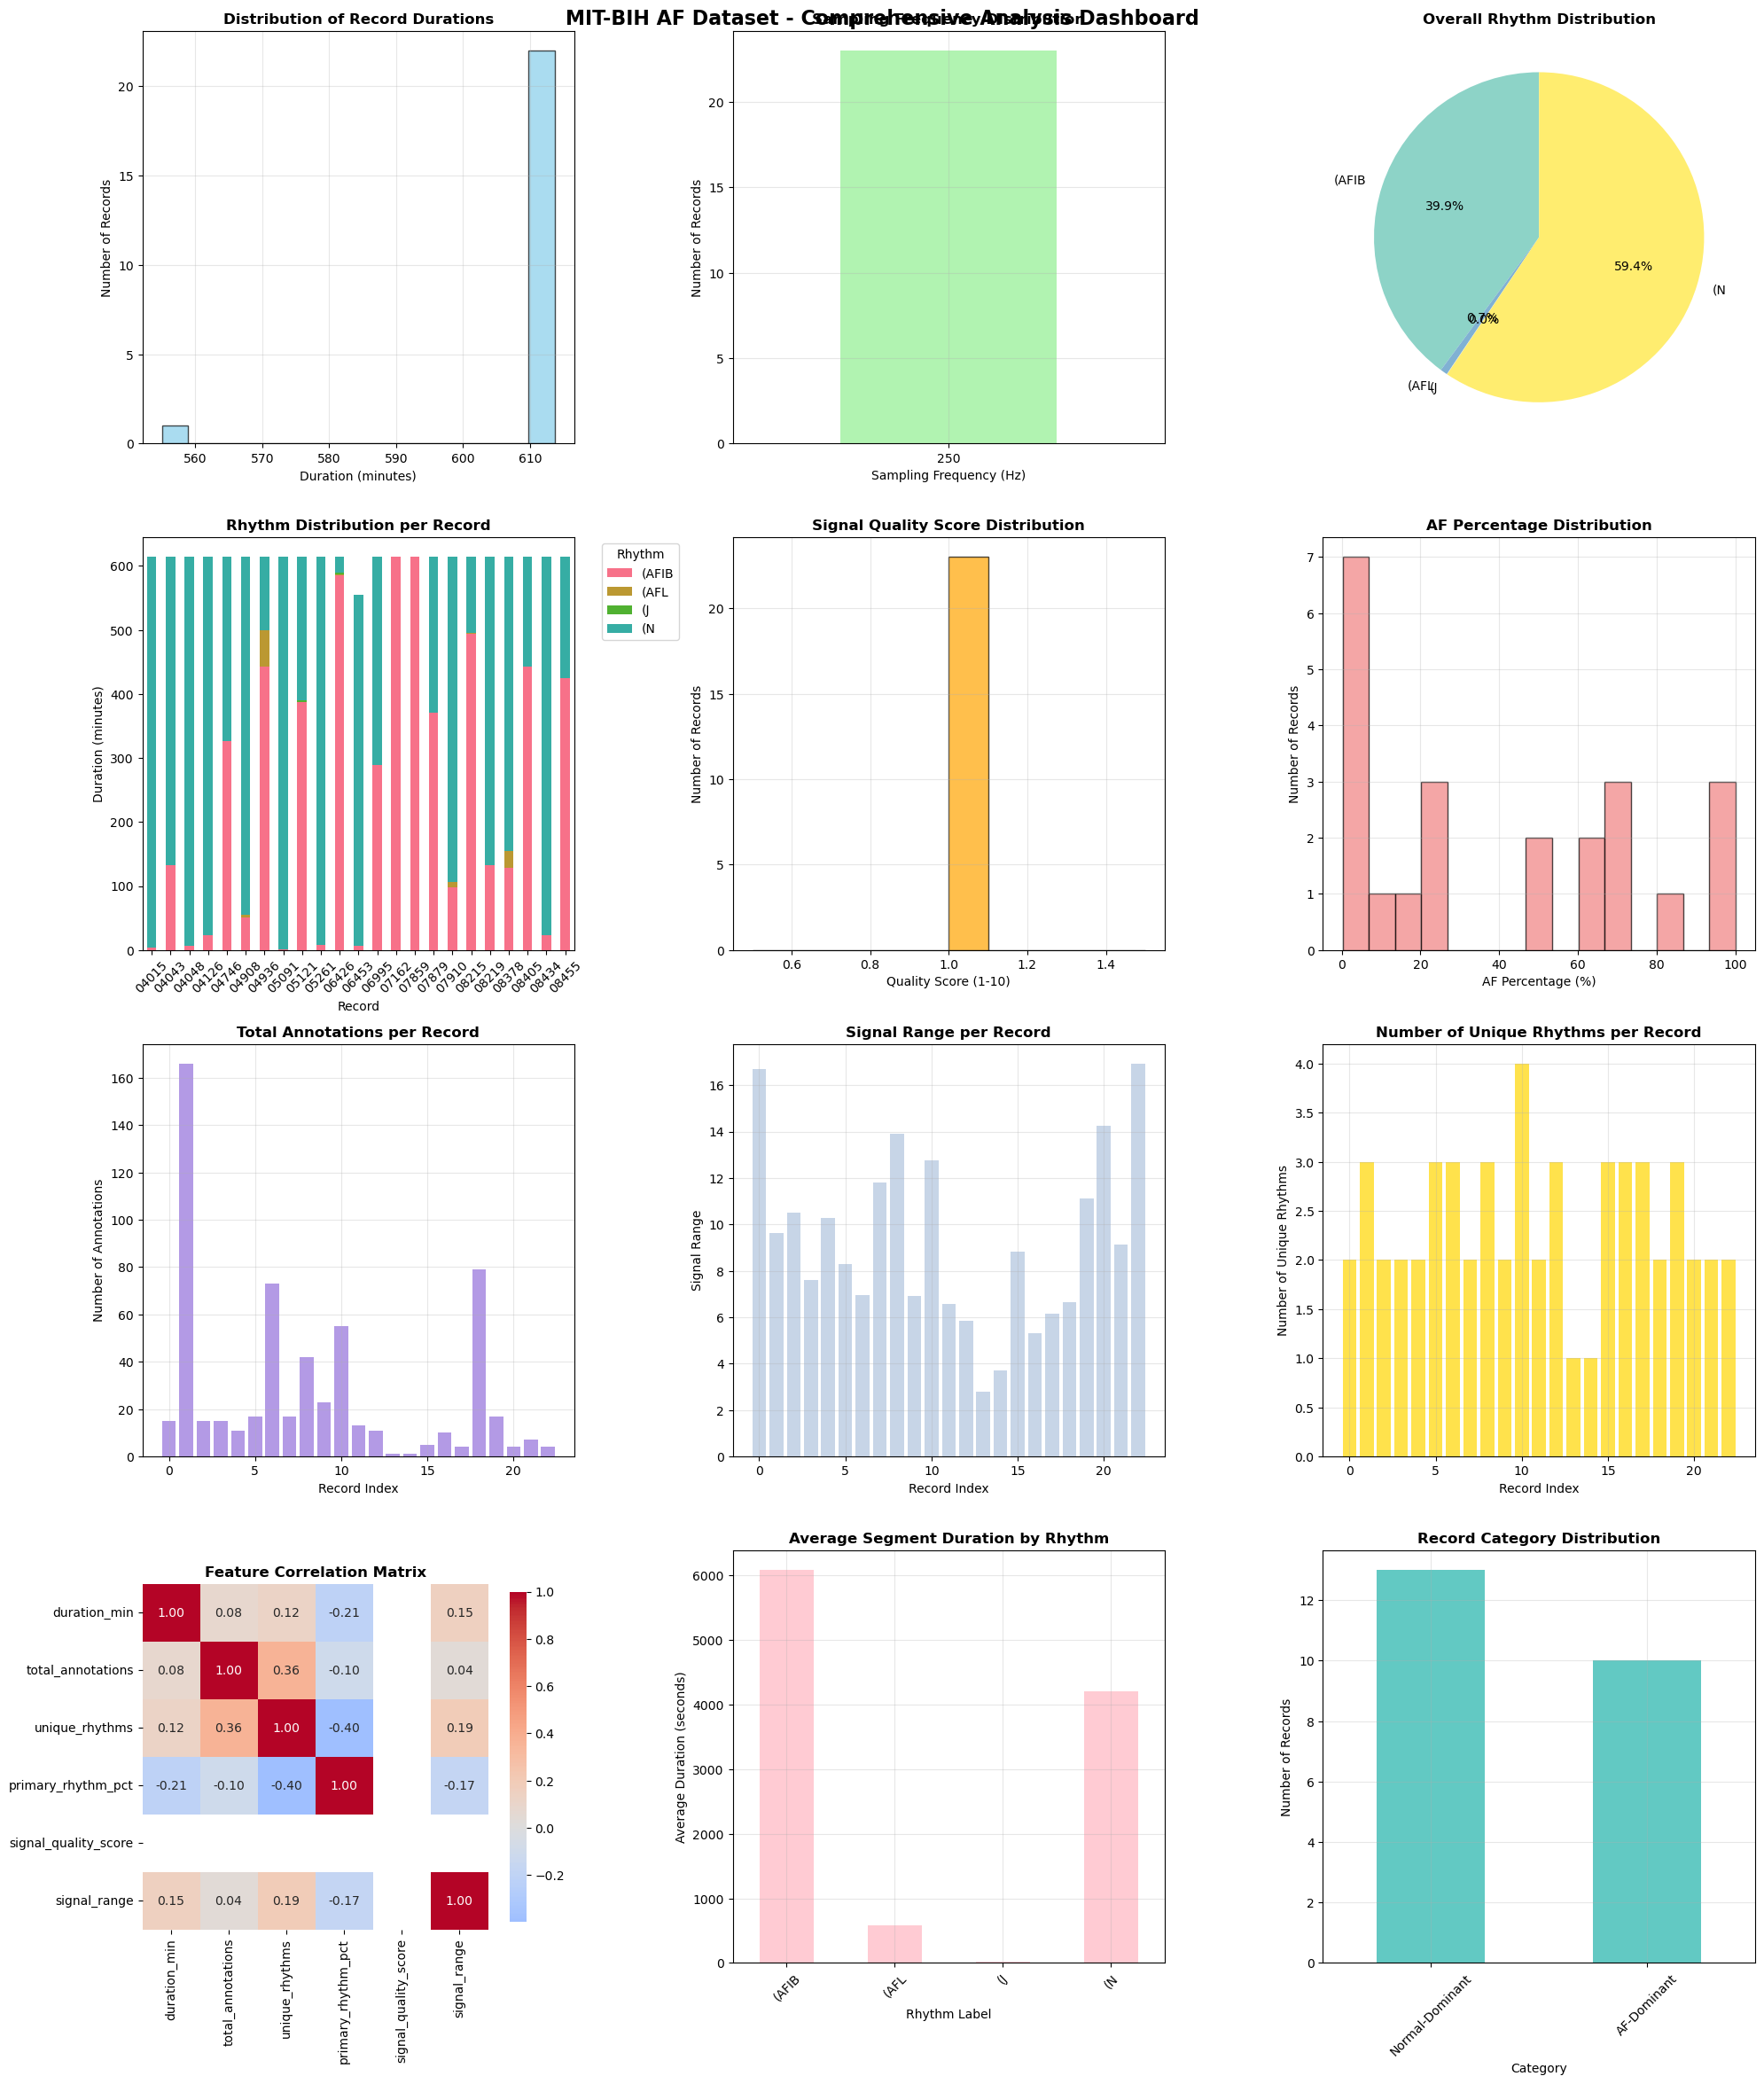

In [15]:
# Create comprehensive visualization dashboard
fig, axes = plt.subplots(4, 3, figsize=(20, 24))
fig.suptitle('MIT-BIH AF Dataset - Comprehensive Analysis Dashboard', fontsize=16, fontweight='bold')

# 1. Record duration distribution
axes[0, 0].hist(metadata_df['duration_min'], bins=15, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribution of Record Durations', fontweight='bold')
axes[0, 0].set_xlabel('Duration (minutes)')
axes[0, 0].set_ylabel('Number of Records')
axes[0, 0].grid(True, alpha=0.3)

# 2. Sampling frequency distribution
fs_counts = metadata_df['sampling_freq'].value_counts()
fs_counts.plot(kind='bar', ax=axes[0, 1], color='lightgreen', alpha=0.7)
axes[0, 1].set_title('Sampling Frequency Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Sampling Frequency (Hz)')
axes[0, 1].set_ylabel('Number of Records')
axes[0, 1].tick_params(axis='x', rotation=0)
axes[0, 1].grid(True, alpha=0.3)

# 3. Overall rhythm distribution (pie chart)
rhythm_totals = detailed_df.groupby('rhythm_label')['total_duration_min'].sum()
colors = plt.cm.Set3(np.linspace(0, 1, len(rhythm_totals)))
wedges, texts, autotexts = axes[0, 2].pie(rhythm_totals.values, labels=rhythm_totals.index, 
                                         autopct='%1.1f%%', colors=colors, startangle=90)
axes[0, 2].set_title('Overall Rhythm Distribution', fontweight='bold')

# 4. Rhythm distribution per record (stacked bar)
pivot_data = detailed_df.pivot_table(
    index='record', columns='rhythm_label', 
    values='total_duration_min', fill_value=0
)
pivot_data.plot(kind='bar', stacked=True, ax=axes[1, 0])
axes[1, 0].set_title('Rhythm Distribution per Record', fontweight='bold')
axes[1, 0].set_xlabel('Record')
axes[1, 0].set_ylabel('Duration (minutes)')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].legend(title='Rhythm', bbox_to_anchor=(1.05, 1), loc='upper left')

# 5. Signal quality scores
axes[1, 1].hist(metadata_df['signal_quality_score'], bins=10, alpha=0.7, color='orange', edgecolor='black')
axes[1, 1].set_title('Signal Quality Score Distribution', fontweight='bold')
axes[1, 1].set_xlabel('Quality Score (1-10)')
axes[1, 1].set_ylabel('Number of Records')
axes[1, 1].grid(True, alpha=0.3)

# 6. AF percentage distribution
axes[1, 2].hist(enhanced_metadata['af_percentage'], bins=15, alpha=0.7, color='lightcoral', edgecolor='black')
axes[1, 2].set_title('AF Percentage Distribution', fontweight='bold')
axes[1, 2].set_xlabel('AF Percentage (%)')
axes[1, 2].set_ylabel('Number of Records')
axes[1, 2].grid(True, alpha=0.3)

# 7. Total annotations per record
axes[2, 0].bar(range(len(metadata_df)), metadata_df['total_annotations'], color='mediumpurple', alpha=0.7)
axes[2, 0].set_title('Total Annotations per Record', fontweight='bold')
axes[2, 0].set_xlabel('Record Index')
axes[2, 0].set_ylabel('Number of Annotations')
axes[2, 0].grid(True, alpha=0.3)

# 8. Signal range per record
axes[2, 1].bar(range(len(metadata_df)), metadata_df['signal_range'], color='lightsteelblue', alpha=0.7)
axes[2, 1].set_title('Signal Range per Record', fontweight='bold')
axes[2, 1].set_xlabel('Record Index')
axes[2, 1].set_ylabel('Signal Range')
axes[2, 1].grid(True, alpha=0.3)

# 9. Unique rhythms per record
axes[2, 2].bar(range(len(metadata_df)), metadata_df['unique_rhythms'], color='gold', alpha=0.7)
axes[2, 2].set_title('Number of Unique Rhythms per Record', fontweight='bold')
axes[2, 2].set_xlabel('Record Index')
axes[2, 2].set_ylabel('Number of Unique Rhythms')
axes[2, 2].grid(True, alpha=0.3)

# 10. Correlation heatmap
numeric_cols = ['duration_min', 'total_annotations', 'unique_rhythms', 
               'primary_rhythm_pct', 'signal_quality_score', 'signal_range']
corr_matrix = metadata_df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
           square=True, fmt='.2f', cbar_kws={'shrink': 0.8}, ax=axes[3, 0])
axes[3, 0].set_title('Feature Correlation Matrix', fontweight='bold')

# 11. Average segment duration by rhythm
avg_seg_duration = detailed_df.groupby('rhythm_label')['avg_segment_duration'].mean()
avg_seg_duration.plot(kind='bar', ax=axes[3, 1], color='lightpink', alpha=0.7)
axes[3, 1].set_title('Average Segment Duration by Rhythm', fontweight='bold')
axes[3, 1].set_xlabel('Rhythm Label')
axes[3, 1].set_ylabel('Average Duration (seconds)')
axes[3, 1].tick_params(axis='x', rotation=45)
axes[3, 1].grid(True, alpha=0.3)

# 12. Record category distribution
category_counts = enhanced_metadata['record_category'].value_counts()
category_counts.plot(kind='bar', ax=axes[3, 2], color='lightseagreen', alpha=0.7)
axes[3, 2].set_title('Record Category Distribution', fontweight='bold')
axes[3, 2].set_xlabel('Category')
axes[3, 2].set_ylabel('Number of Records')
axes[3, 2].tick_params(axis='x', rotation=45)
axes[3, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Normal vs AF Detailed Comparison

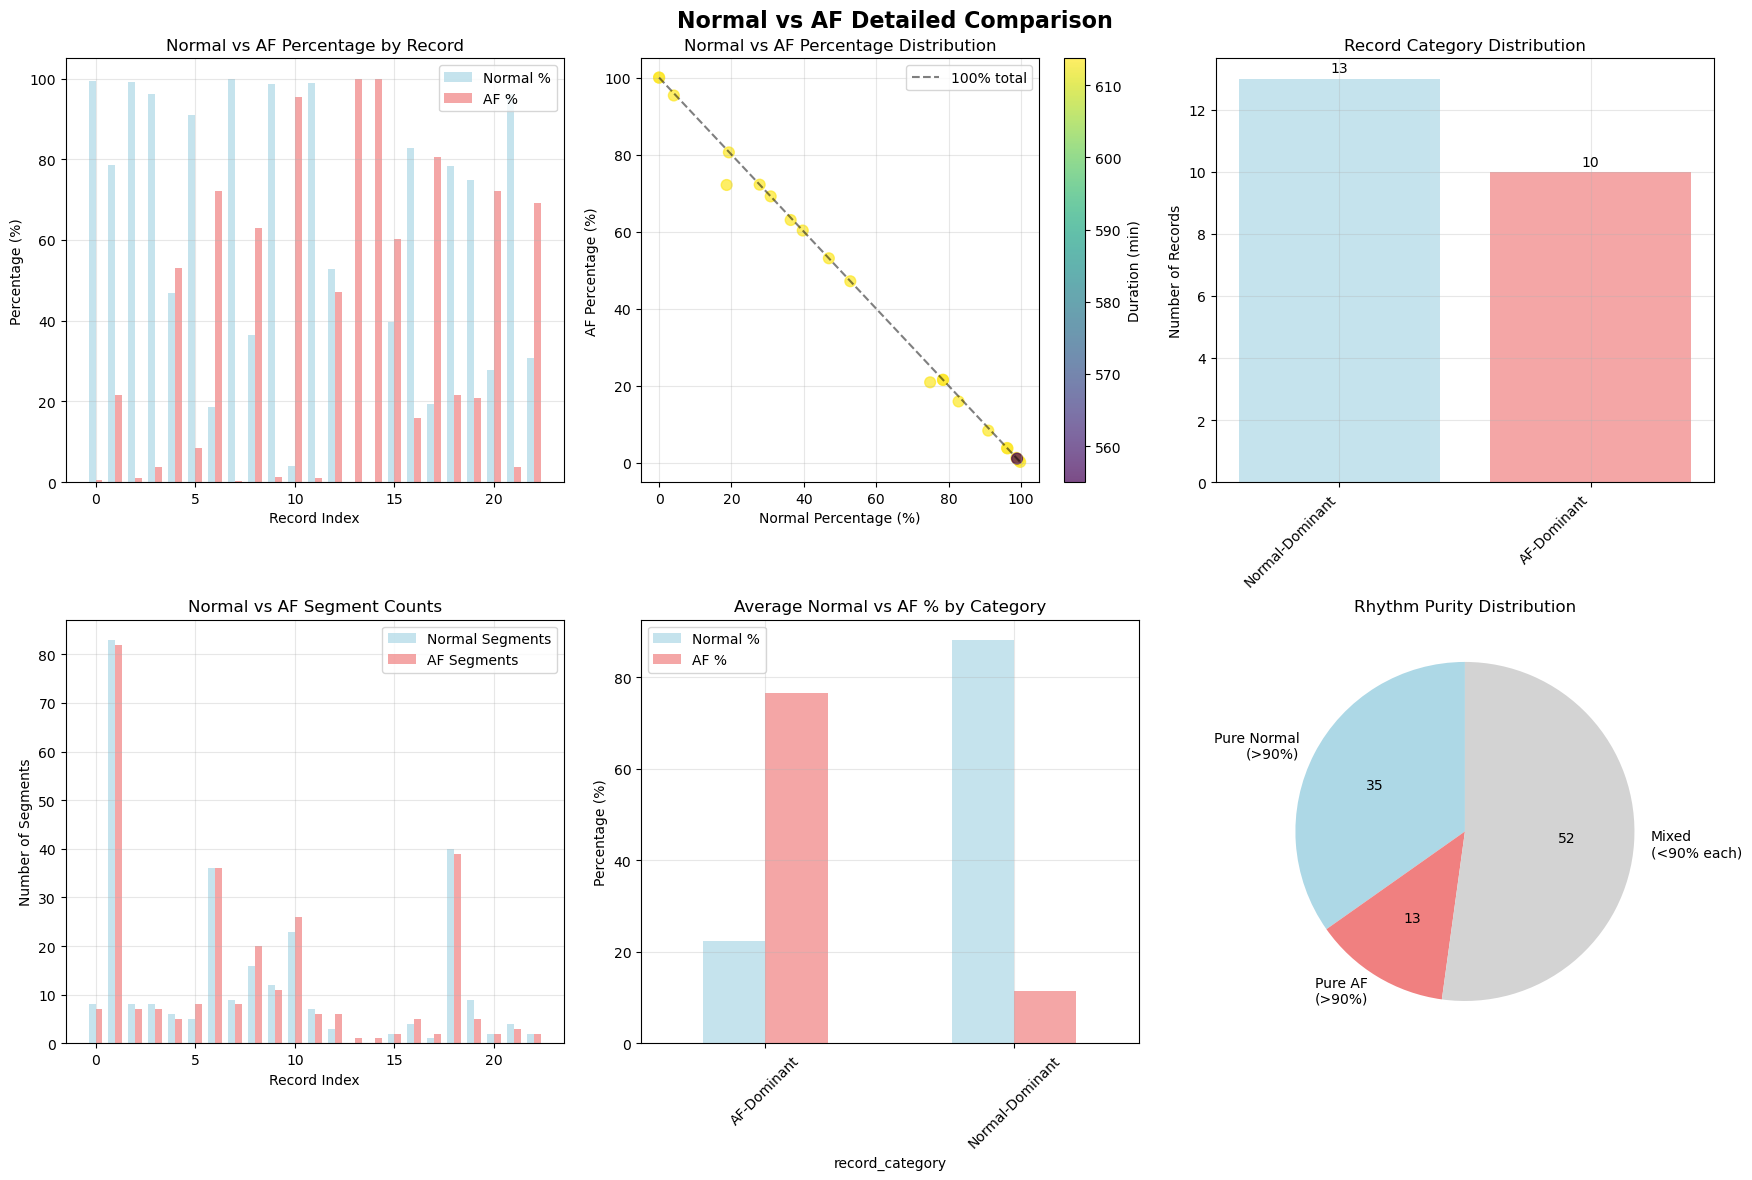


=== NORMAL vs AF SUMMARY ===
Total Normal time: 8349.3 minutes (59.4% of dataset)
Total AF time: 5603.9 minutes (39.9% of dataset)
Records with Normal rhythm: 21
Records with AF rhythm: 23
Records with both Normal and AF: 21


In [16]:
# Enhanced Normal vs AF analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Normal vs AF Detailed Comparison', fontsize=16, fontweight='bold')

# 1. Normal vs AF duration comparison
x_pos = range(len(enhanced_metadata))
width = 0.35

bars1 = axes[0, 0].bar([x - width/2 for x in x_pos], enhanced_metadata['normal_percentage'], width, 
                      label='Normal %', alpha=0.7, color='lightblue')
bars2 = axes[0, 0].bar([x + width/2 for x in x_pos], enhanced_metadata['af_percentage'], width,
                      label='AF %', alpha=0.7, color='lightcoral')
axes[0, 0].set_xlabel('Record Index')
axes[0, 0].set_ylabel('Percentage (%)')
axes[0, 0].set_title('Normal vs AF Percentage by Record')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Scatter plot: Normal vs AF percentage
scatter = axes[0, 1].scatter(enhanced_metadata['normal_percentage'], enhanced_metadata['af_percentage'],
                           c=enhanced_metadata['duration_min'], cmap='viridis', alpha=0.7, s=60)
axes[0, 1].set_xlabel('Normal Percentage (%)')
axes[0, 1].set_ylabel('AF Percentage (%)')
axes[0, 1].set_title('Normal vs AF Percentage Distribution')
axes[0, 1].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[0, 1], label='Duration (min)')

# Add diagonal line for reference
max_pct = 100
axes[0, 1].plot([0, max_pct], [max_pct, 0], 'k--', alpha=0.5, label='100% total')
axes[0, 1].legend()

# 3. Record category distribution (updated)
category_counts = enhanced_metadata['record_category'].value_counts()
bars = axes[0, 2].bar(range(len(category_counts)), category_counts.values, 
                     color=['lightblue', 'lightcoral', 'yellow', 'orange', 'purple', 'green', 'gray'], alpha=0.7)
axes[0, 2].set_title('Record Category Distribution')
axes[0, 2].set_ylabel('Number of Records')
axes[0, 2].set_xticks(range(len(category_counts)))
axes[0, 2].set_xticklabels(category_counts.index, rotation=45, ha='right')
axes[0, 2].grid(True, alpha=0.3)

# Add value labels
for i, bar in enumerate(bars):
    height = bar.get_height()
    axes[0, 2].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                   f'{int(height)}', ha='center', va='bottom')

# 4. Normal vs AF segment counts
axes[1, 0].bar([x - width/2 for x in x_pos], enhanced_metadata['normal_segments'], width, 
              label='Normal Segments', alpha=0.7, color='lightblue')
axes[1, 0].bar([x + width/2 for x in x_pos], enhanced_metadata['af_segments'], width,
              label='AF Segments', alpha=0.7, color='lightcoral')
axes[1, 0].set_xlabel('Record Index')
axes[1, 0].set_ylabel('Number of Segments')
axes[1, 0].set_title('Normal vs AF Segment Counts')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 5. Average percentages by category
category_stats = enhanced_metadata.groupby('record_category')[['normal_percentage', 'af_percentage']].mean()
category_stats.plot(kind='bar', ax=axes[1, 1], color=['lightblue', 'lightcoral'], alpha=0.7)
axes[1, 1].set_title('Average Normal vs AF % by Category')
axes[1, 1].set_ylabel('Percentage (%)')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].legend(['Normal %', 'AF %'])
axes[1, 1].grid(True, alpha=0.3)

# 6. Rhythm purity analysis (records with >90% single rhythm)
pure_normal = len(enhanced_metadata[enhanced_metadata['normal_percentage'] > 90])
pure_af = len(enhanced_metadata[enhanced_metadata['af_percentage'] > 90])
mixed_records = len(enhanced_metadata) - pure_normal - pure_af

purity_data = [pure_normal, pure_af, mixed_records]
purity_labels = ['Pure Normal\n(>90%)', 'Pure AF\n(>90%)', 'Mixed\n(<90% each)']
colors_purity = ['lightblue', 'lightcoral', 'lightgray']

axes[1, 2].pie(purity_data, labels=purity_labels, autopct='%1.0f', colors=colors_purity, startangle=90)
axes[1, 2].set_title('Rhythm Purity Distribution')

plt.tight_layout()
plt.show()

# Print Normal vs AF summary
print("\n=== NORMAL vs AF SUMMARY ===")
total_normal_time = enhanced_metadata['normal_duration_min'].sum()
total_af_time = enhanced_metadata['af_duration_min'].sum()
total_time = enhanced_metadata['duration_min'].sum()

print(f"Total Normal time: {total_normal_time:.1f} minutes ({total_normal_time/total_time*100:.1f}% of dataset)")
print(f"Total AF time: {total_af_time:.1f} minutes ({total_af_time/total_time*100:.1f}% of dataset)")
print(f"Records with Normal rhythm: {len(enhanced_metadata[enhanced_metadata['normal_percentage'] > 0])}")
print(f"Records with AF rhythm: {len(enhanced_metadata[enhanced_metadata['af_percentage'] > 0])}")
print(f"Records with both Normal and AF: {len(enhanced_metadata[(enhanced_metadata['normal_percentage'] > 0) & (enhanced_metadata['af_percentage'] > 0)])}")

All Rhythm Types Analysis

=== ALL RHYTHM TYPES IN DATASET ===
Found 4 unique rhythm types:
  '(AFIB': 5603.9 min, 23 records, 291 segments
  '(AFL': 98.0 min, 8 records, 14 segments
  '(J': 5.5 min, 3 records, 12 segments
  '(N': 8349.3 min, 21 records, 288 segments


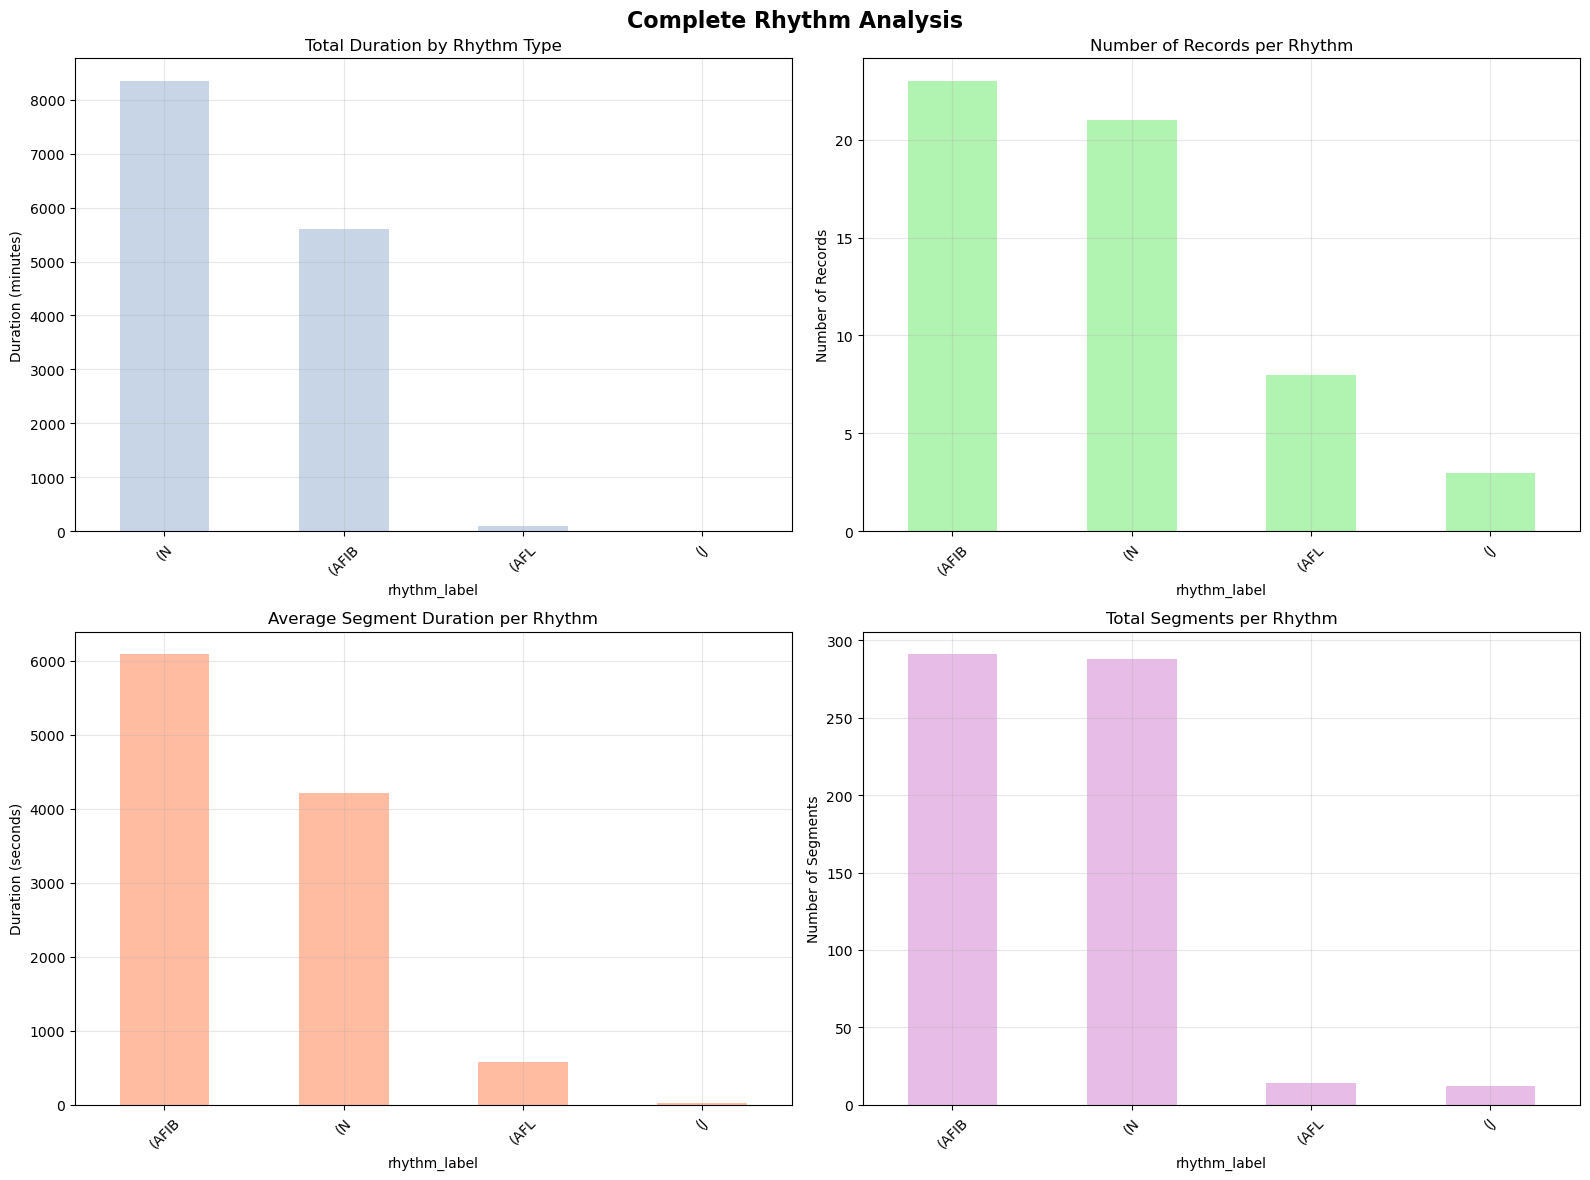

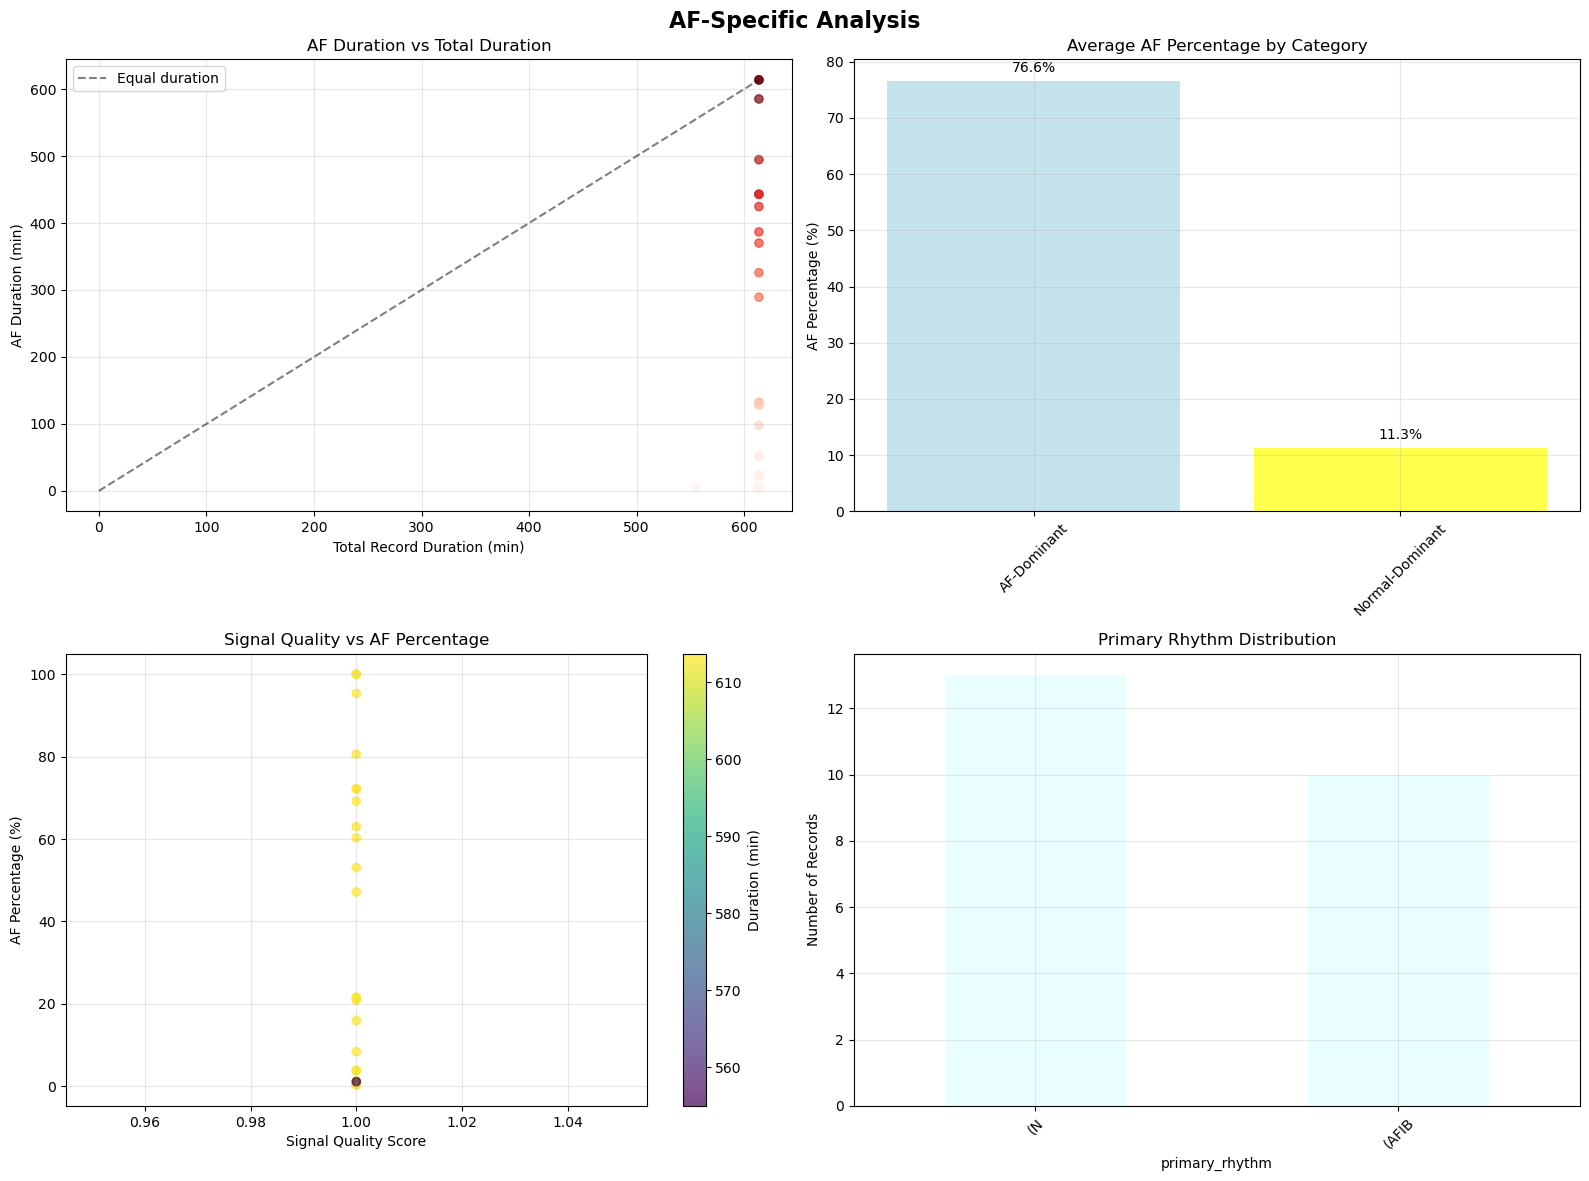

In [17]:
# Show all unique rhythm types found in dataset
print("=== ALL RHYTHM TYPES IN DATASET ===")
all_rhythms = detailed_df['rhythm_label'].unique()
print(f"Found {len(all_rhythms)} unique rhythm types:")
for rhythm in sorted(all_rhythms):
    total_time = detailed_df[detailed_df['rhythm_label'] == rhythm]['total_duration_min'].sum()
    num_records = detailed_df[detailed_df['rhythm_label'] == rhythm]['record'].nunique()
    num_segments = detailed_df[detailed_df['rhythm_label'] == rhythm]['segment_count'].sum()
    print(f"  '{rhythm}': {total_time:.1f} min, {num_records} records, {num_segments} segments")

# Create detailed rhythm analysis plot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Complete Rhythm Analysis', fontsize=16, fontweight='bold')

# 1. All rhythms duration (bar chart)
rhythm_durations = detailed_df.groupby('rhythm_label')['total_duration_min'].sum().sort_values(ascending=False)
rhythm_durations.plot(kind='bar', ax=axes[0, 0], color='lightsteelblue', alpha=0.7)
axes[0, 0].set_title('Total Duration by Rhythm Type')
axes[0, 0].set_ylabel('Duration (minutes)')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)

# 2. Number of records per rhythm
rhythm_records = detailed_df.groupby('rhythm_label')['record'].nunique().sort_values(ascending=False)
rhythm_records.plot(kind='bar', ax=axes[0, 1], color='lightgreen', alpha=0.7)
axes[0, 1].set_title('Number of Records per Rhythm')
axes[0, 1].set_ylabel('Number of Records')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# 3. Average segment duration per rhythm
avg_segment_durations = detailed_df.groupby('rhythm_label')['avg_segment_duration'].mean().sort_values(ascending=False)
avg_segment_durations.plot(kind='bar', ax=axes[1, 0], color='lightsalmon', alpha=0.7)
axes[1, 0].set_title('Average Segment Duration per Rhythm')
axes[1, 0].set_ylabel('Duration (seconds)')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# 4. Total segments per rhythm
total_segments = detailed_df.groupby('rhythm_label')['segment_count'].sum().sort_values(ascending=False)
total_segments.plot(kind='bar', ax=axes[1, 1], color='plum', alpha=0.7)
axes[1, 1].set_title('Total Segments per Rhythm')
axes[1, 1].set_ylabel('Number of Segments')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# %%
# AF-specific detailed analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('AF-Specific Analysis', fontsize=16, fontweight='bold')

# 1. AF duration vs record duration
axes[0, 0].scatter(enhanced_metadata['duration_min'], enhanced_metadata['af_duration_min'], 
                  c=enhanced_metadata['af_percentage'], cmap='Reds', alpha=0.7)
axes[0, 0].set_xlabel('Total Record Duration (min)')
axes[0, 0].set_ylabel('AF Duration (min)')
axes[0, 0].set_title('AF Duration vs Total Duration')
axes[0, 0].grid(True, alpha=0.3)

# Add diagonal line
max_duration = max(enhanced_metadata['duration_min'])
axes[0, 0].plot([0, max_duration], [0, max_duration], 'k--', alpha=0.5, label='Equal duration')
axes[0, 0].legend()

# 2. AF percentage by record category
category_af = enhanced_metadata.groupby('record_category')['af_percentage'].mean()
bars = axes[0, 1].bar(category_af.index, category_af.values, 
                     color=['lightblue', 'yellow', 'orange', 'red'], alpha=0.7)
axes[0, 1].set_title('Average AF Percentage by Category')
axes[0, 1].set_ylabel('AF Percentage (%)')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 1,
                   f'{height:.1f}%', ha='center', va='bottom')

# 3. Signal quality vs AF percentage
scatter = axes[1, 0].scatter(enhanced_metadata['signal_quality_score'], enhanced_metadata['af_percentage'],
                           c=enhanced_metadata['duration_min'], cmap='viridis', alpha=0.7)
axes[1, 0].set_xlabel('Signal Quality Score')
axes[1, 0].set_ylabel('AF Percentage (%)')
axes[1, 0].set_title('Signal Quality vs AF Percentage')
axes[1, 0].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[1, 0], label='Duration (min)')

# 4. Primary rhythm distribution
primary_rhythm_counts = metadata_df['primary_rhythm'].value_counts()
primary_rhythm_counts.plot(kind='bar', ax=axes[1, 1], color='lightcyan', alpha=0.7)
axes[1, 1].set_title('Primary Rhythm Distribution')
axes[1, 1].set_ylabel('Number of Records')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Signal Quality Analysis

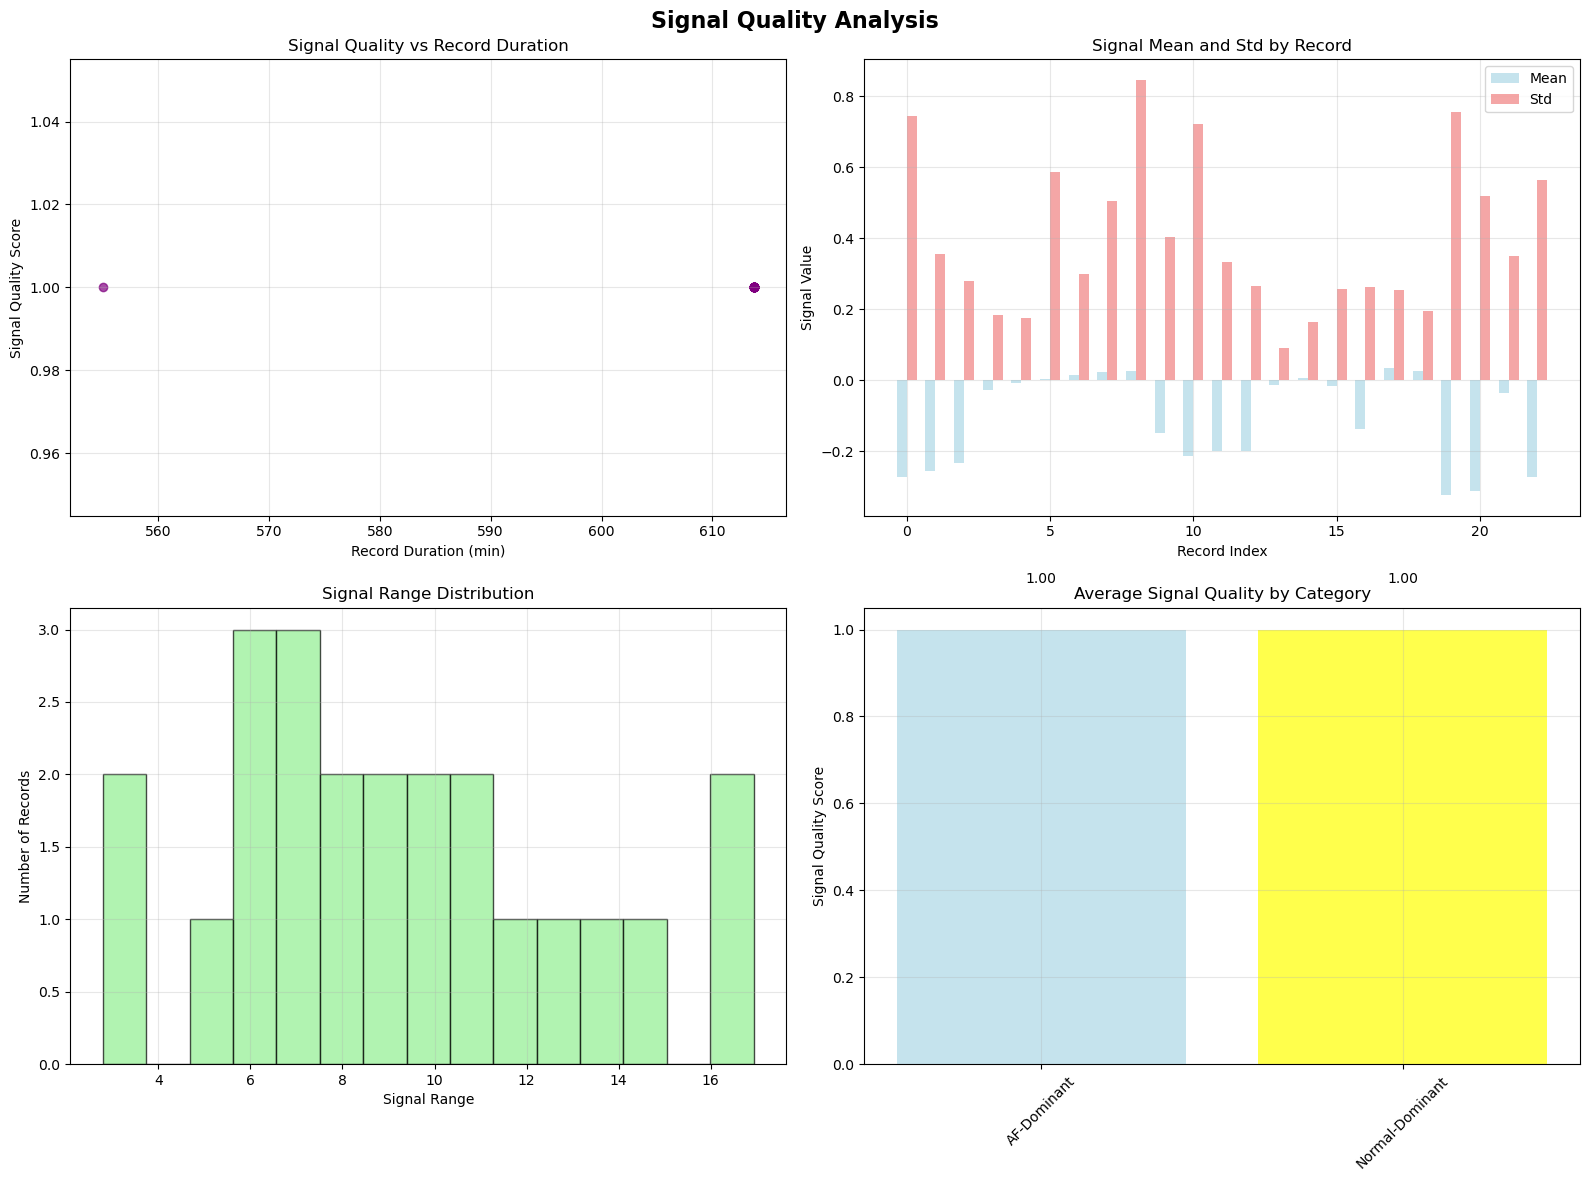

In [18]:
# Signal quality detailed analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Signal Quality Analysis', fontsize=16, fontweight='bold')

# 1. Signal quality vs duration
axes[0, 0].scatter(enhanced_metadata['duration_min'], enhanced_metadata['signal_quality_score'], 
                  alpha=0.7, color='purple')
axes[0, 0].set_xlabel('Record Duration (min)')
axes[0, 0].set_ylabel('Signal Quality Score')
axes[0, 0].set_title('Signal Quality vs Record Duration')
axes[0, 0].grid(True, alpha=0.3)

# 2. Signal statistics by record
x_pos = range(len(metadata_df))
width = 0.35

axes[0, 1].bar([x - width/2 for x in x_pos], metadata_df['signal_mean'], width, 
              label='Mean', alpha=0.7, color='lightblue')
axes[0, 1].bar([x + width/2 for x in x_pos], metadata_df['signal_std'], width,
              label='Std', alpha=0.7, color='lightcoral')
axes[0, 1].set_xlabel('Record Index')
axes[0, 1].set_ylabel('Signal Value')
axes[0, 1].set_title('Signal Mean and Std by Record')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Signal range distribution
axes[1, 0].hist(metadata_df['signal_range'], bins=15, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1, 0].set_xlabel('Signal Range')
axes[1, 0].set_ylabel('Number of Records')
axes[1, 0].set_title('Signal Range Distribution')
axes[1, 0].grid(True, alpha=0.3)

# 4. Quality score by category
quality_by_category = enhanced_metadata.groupby('record_category')['signal_quality_score'].mean()
bars = axes[1, 1].bar(quality_by_category.index, quality_by_category.values, 
                     color=['lightblue', 'yellow', 'orange', 'red'], alpha=0.7)
axes[1, 1].set_title('Average Signal Quality by Category')
axes[1, 1].set_ylabel('Signal Quality Score')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                   f'{height:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

Summary Statistics

In [19]:
print("\n=== FINAL SUMMARY ===")
print(f"Dataset contains {len(metadata_df)} records with total duration of {total_duration_hours:.2f} hours")
print(f"AF is present in {len(enhanced_metadata[enhanced_metadata['af_percentage'] > 0])} records")
print(f"Average signal quality score: {metadata_df['signal_quality_score'].mean():.2f}/10")
print(f"Most common rhythm: {rhythm_summary.index[0]} ({rhythm_summary.iloc[0]['percentage_of_dataset']:.1f}% of total time)")
print(f"Records by category:")
for category, count in enhanced_metadata['record_category'].value_counts().items():
    print(f"  - {category}: {count} records")


=== FINAL SUMMARY ===
Dataset contains 23 records with total duration of 234.28 hours
AF is present in 23 records
Average signal quality score: 1.00/10
Most common rhythm: (N (59.4% of total time)
Records by category:
  - Normal-Dominant: 13 records
  - AF-Dominant: 10 records
